# Лабораторная работа 1: «Метод обратного распространения ошибки»

## Цели работы

**Цель** — изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети (один скрытый слой).

## Задачи работы

Выполнение работы предполагает решение следующих задач:

1. Изучение общей схемы работы метода обратного распространения ошибки с помощью стохастического градиентного спуска.
2. Вывод математических формул для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
3. Реализация и тестирование метода обратного распространения ошибки для классификации рукописных цифр из набора данных [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset).


Конфигурация нейронной сети:

1. Входной слой содержит `w x h` нейронов, что соответствует разрешению одноканального изображения (для изображений в базе MNIST составляет 28x28).
2. Выходной слой содержит `k` нейронов, что соответствует количеству классов изображений (для задачи классификации рукописных цифр MNIST – 10 классов).
3. Скрытый слой содержит `s` нейронов (параметр).
4. Скорость обучения (learning rate), размер пачки данных (batch size), количество эпох являются параметрами метода обучения.
5. В качестве функции активации на скрытом слое используется функция ReLU. В качестве функции активации на выходном слое используется функция softmax. Входной слой не содержит функцию активации.
6. В качестве функции ошибки используется кросс-энтропия. Функция активации softmax вместе с функцией ошибки кросс-энтропия упрощают вывод формул.
7. Набор параметров для демонстрации работы нейронной сети (и выложенные материалы и демонстрации в т/к выполняется на данных параметрах):
    - Размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти).
    - Скорость обучения - 0.1.
    - Количество скрытых нейронов `s` - 300.
    - Количество эпох – 20.

In [20]:
import numpy as np
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt
import time

## Класс для загрузки набора данных MNIST

In [21]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)

        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)

        return (x_train, y_train), (x_test, y_test)

#### Вспомогательная функция для визуализации изображений с соответствующими метками:

In [22]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 10);
        index += 1

## Загрузка и проверка корректности данных

In [23]:
input_path = 'mnist/'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

print("Размер тренировочных данных: x_train = ", x_train.shape, ", y_train = ", y_train.shape)
print("Размер тестовых данных: x_test = ", x_test.shape, ", y_test = ", y_test.shape)

x_train_size = len(x_train)
x_test_size = len(x_test)

Размер тренировочных данных: x_train =  (60000, 28, 28) , y_train =  (60000,)
Размер тестовых данных: x_test =  (10000, 28, 28) , y_test =  (10000,)


#### Демонстрация изображений и их меток из тренировочной выборки:

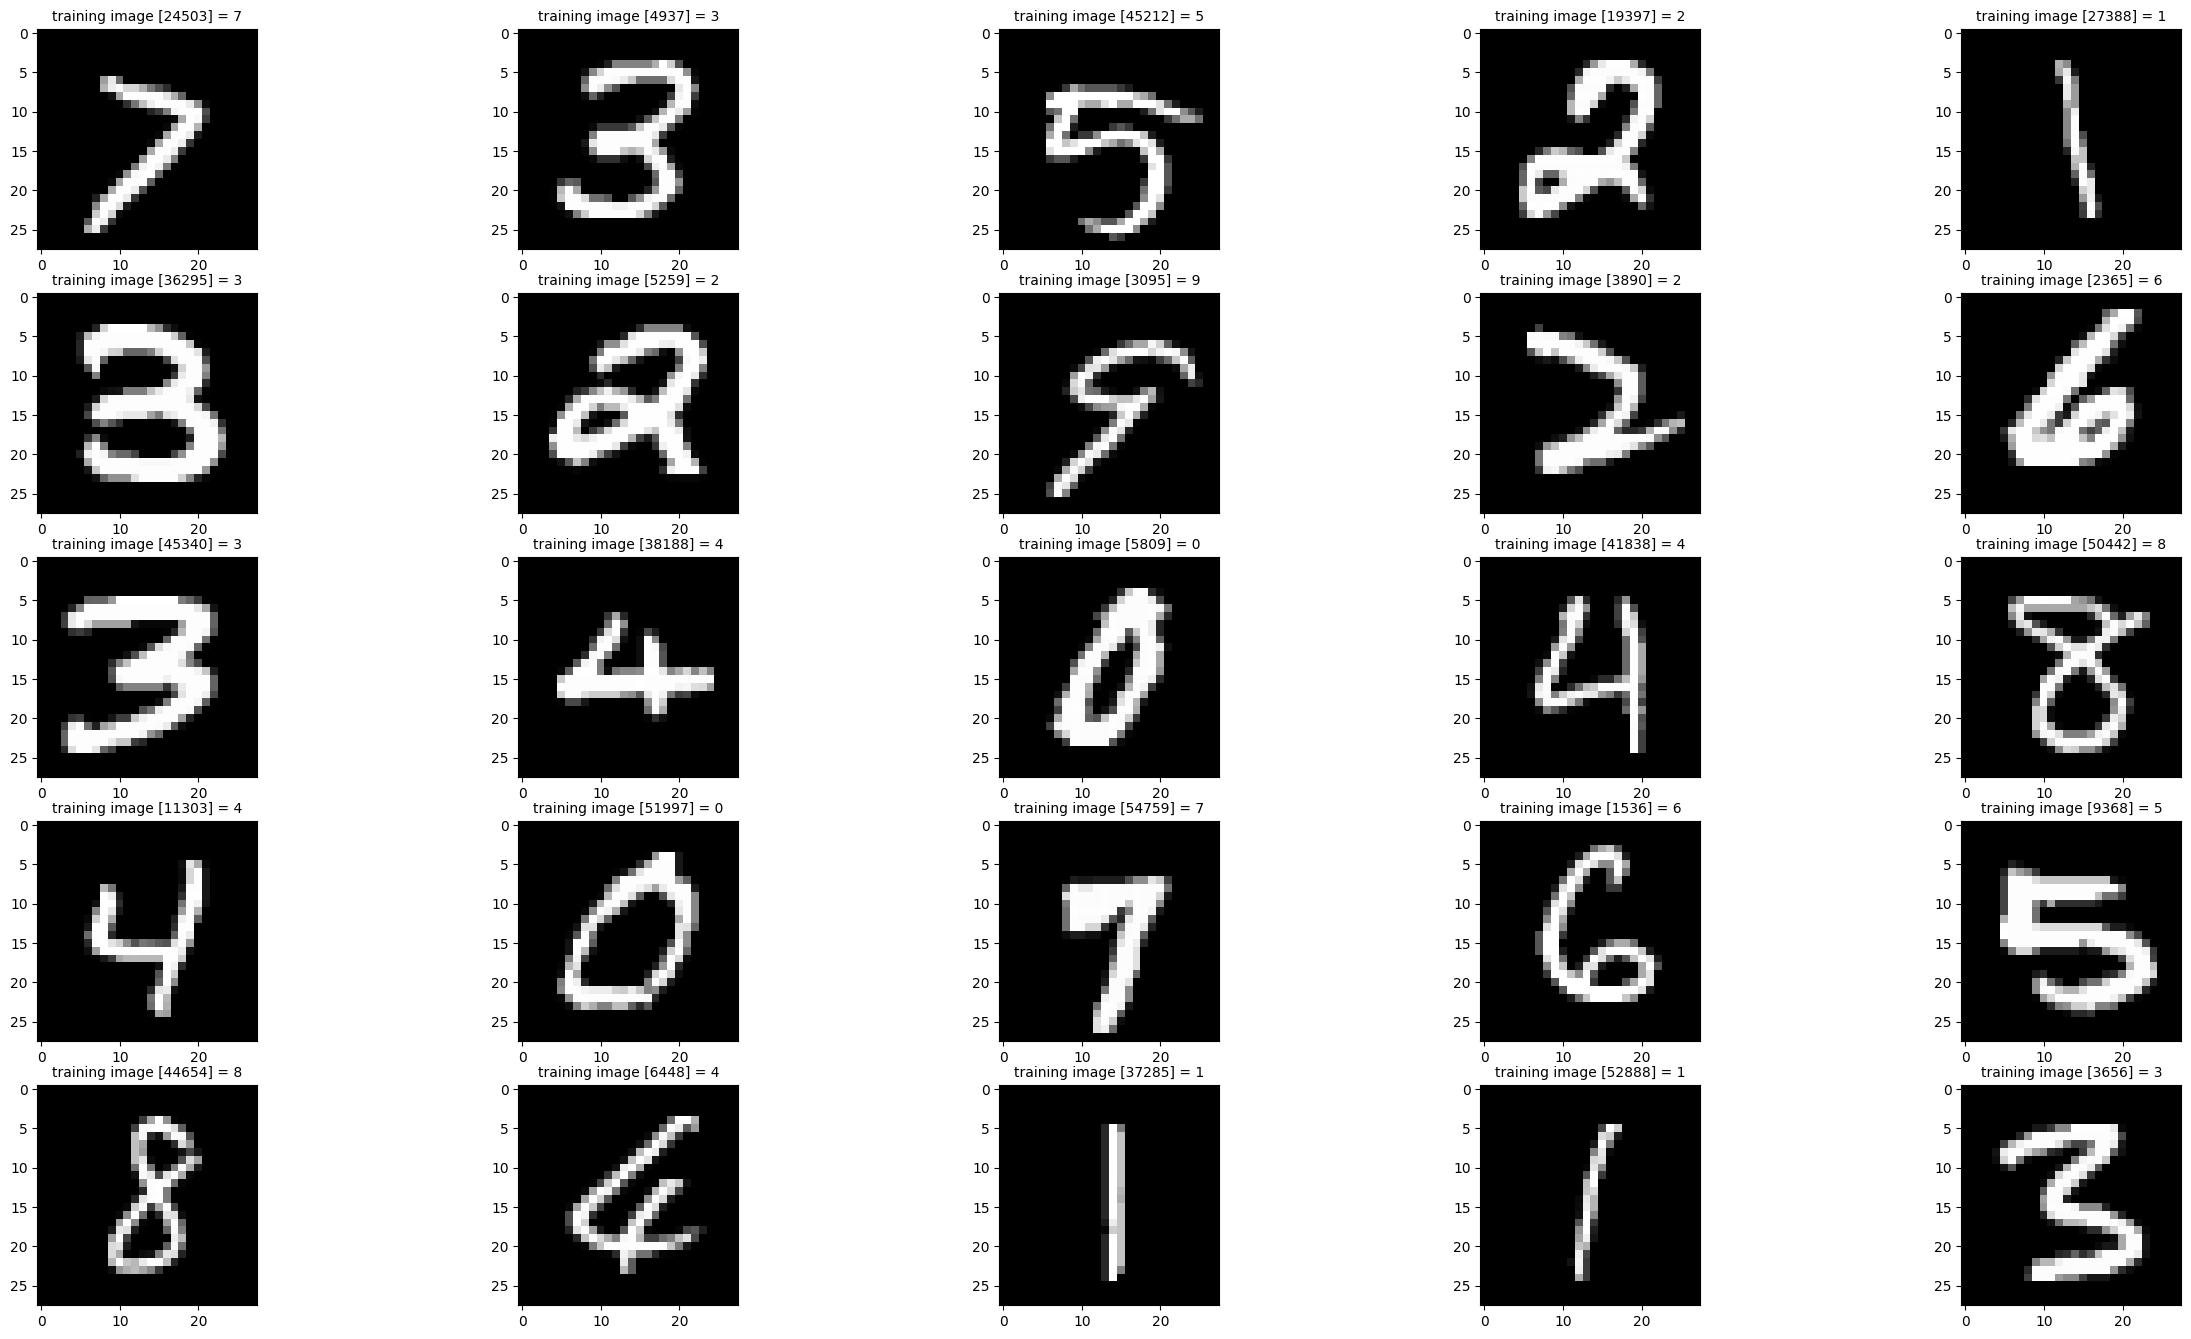

In [24]:
train_images_2_show = []
train_titles_2_show = []
for i in range(0, 25):
    r = random.randint(1, x_train_size)
    train_images_2_show.append(x_train[r])
    train_titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

show_images(train_images_2_show, train_titles_2_show)

#### Демонстрация изображений и их меток из тестовой выборки:

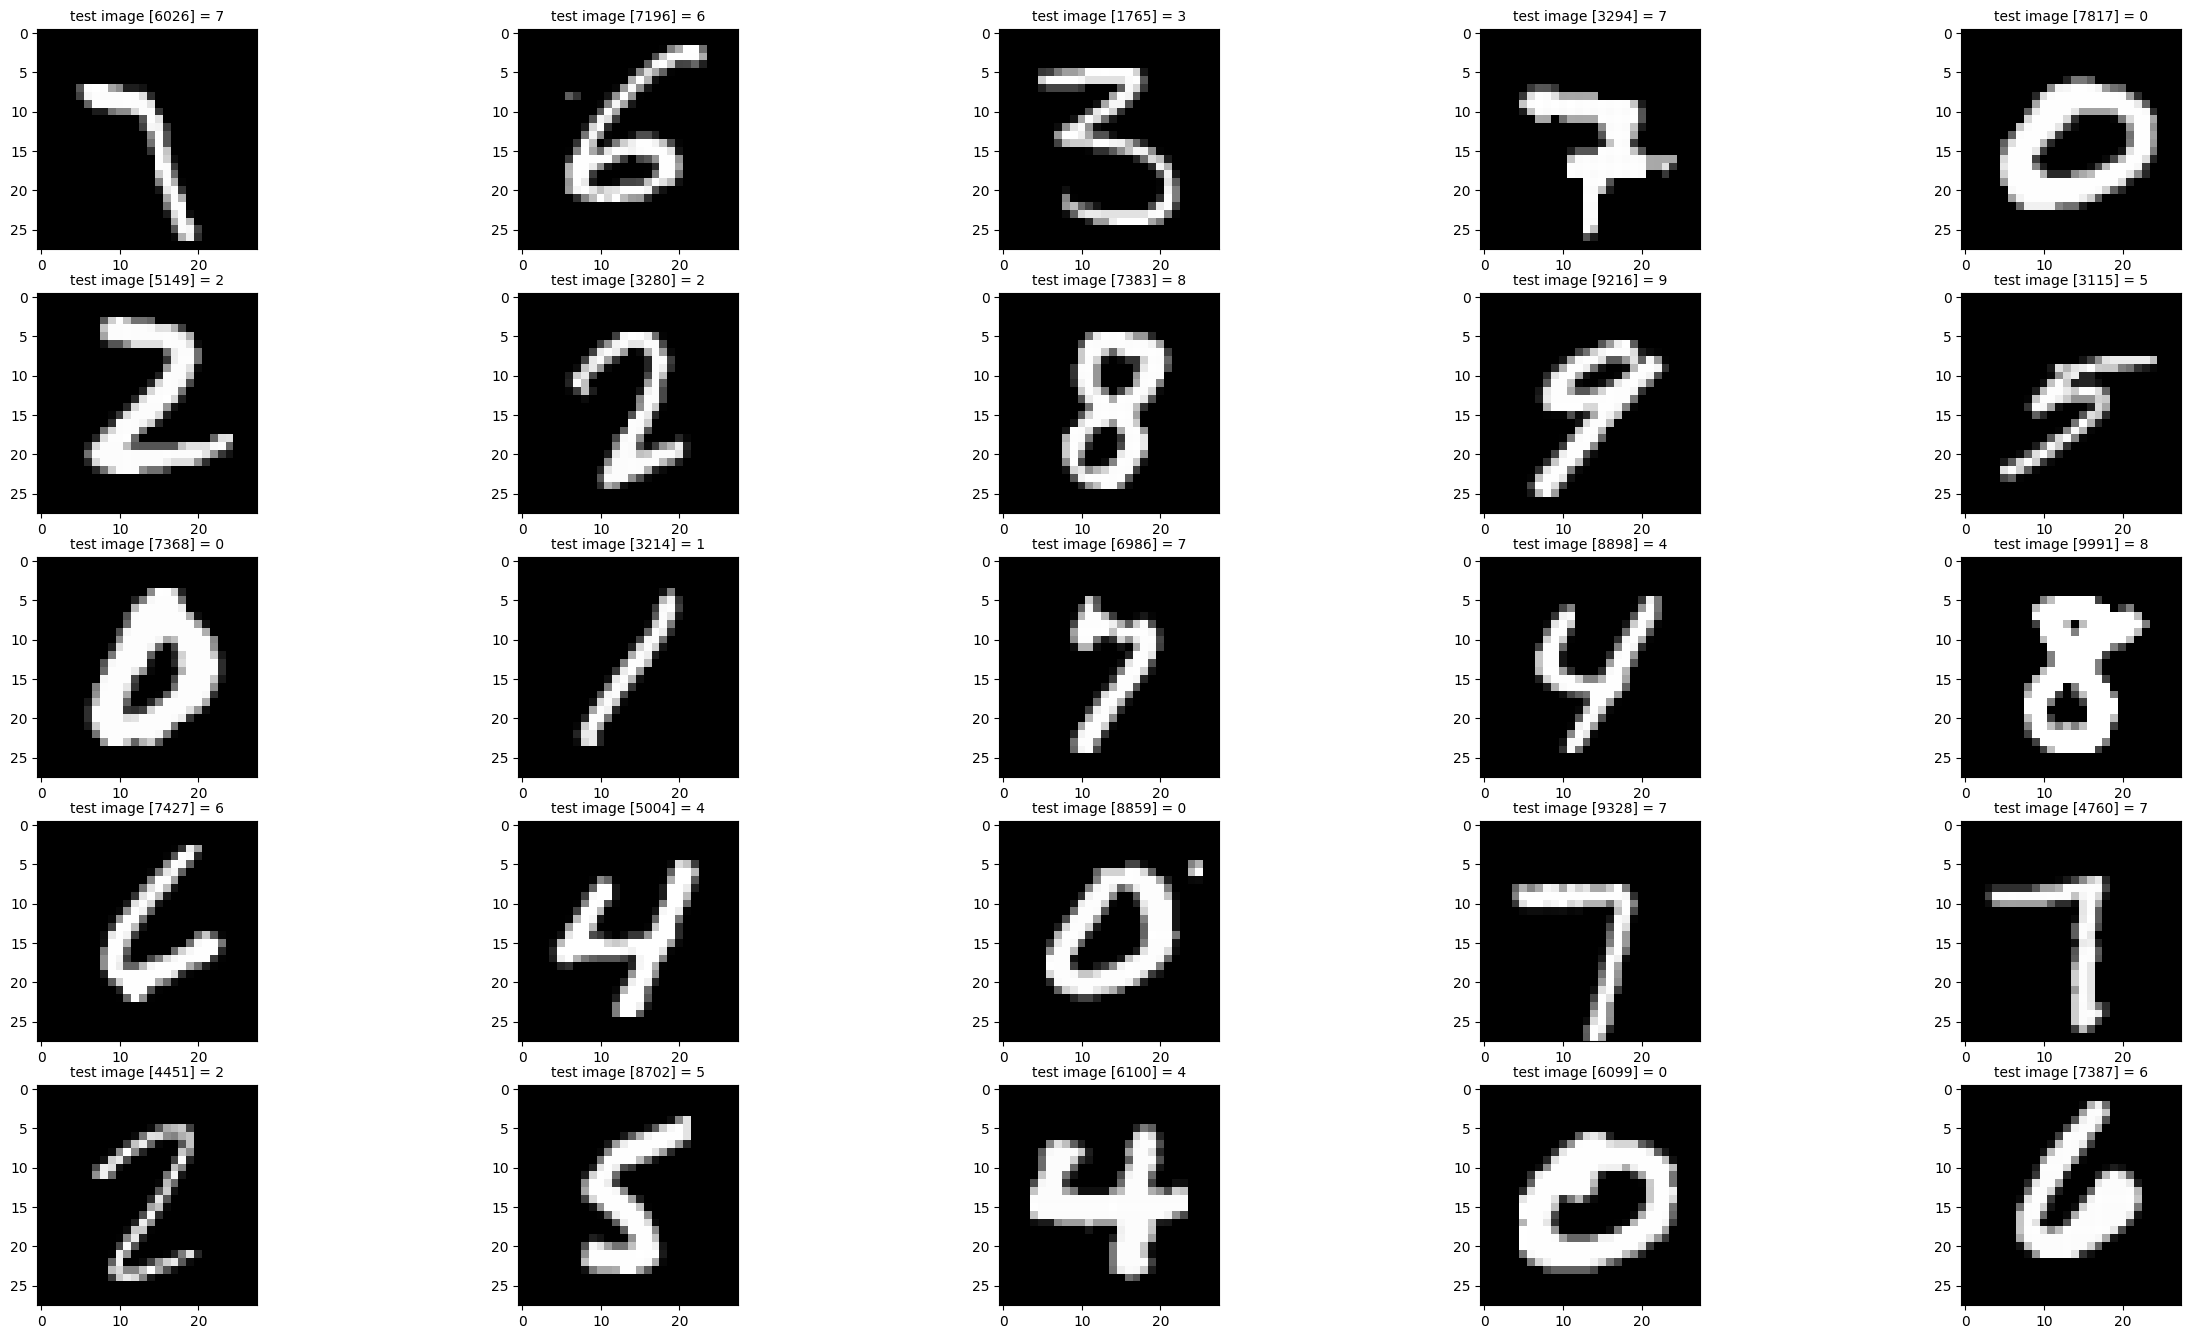

In [25]:
test_images_2_show = []
test_titles_2_show = []
for i in range(0, 25):
    r = random.randint(1, x_test_size)
    test_images_2_show.append(x_test[r])
    test_titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(test_images_2_show, test_titles_2_show)

## Реализация метода обратного распространения ошибки

In [26]:
def ReLU(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(u):
    exp_u = np.exp(u - np.max(u, axis=1, keepdims=True))
    return exp_u / np.sum(exp_u, axis=1, keepdims=True)

def cross_entropy(y, u):
    m = y.shape[0]
    return -np.sum(y * np.log(u)) / m

def accuracy(y, u):
    return np.mean(np.argmax(y, axis=1) == np.argmax(u, axis=1))

In [29]:
class Neural_Network:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Инициализация весов для скрытого слоя
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2.0 / self.input_size)
        # Инициализация весов для выходного слоя
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2.0 / self.hidden_size)

        # Смещения для скрытого слоя
        self.b1 = np.zeros((1, self.hidden_size))
        # Смещения для выходного слоя
        self.b2 = np.zeros((1, self.output_size))

    def forward(self, X):
        # Скрытый слой
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = ReLU(self.z1)

        # Выходной слой
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.y_pred = softmax(self.z2)

        return self.y_pred

    def backward(self, X, y, learning_rate):
        m = X.shape[0]

        # Вычисление ошибки
        self.y_pred = self.forward(X)
        error = self.y_pred - y

        # Вычисление градиентов для выходного слоя
        dW2 = (1 / m) * np.dot(self.a1.T, error)
        db2 = (1 / m) * np.sum(error, axis=0, keepdims=True)

        # Вычисление градиентов для скрытого слоя
        dz1 = np.dot(error, self.W2.T)
        da1 = dz1 * ReLU_derivative(self.z1)
        dW1 = (1 / m) * np.dot(X.T, da1)
        db1 = (1 / m) * np.sum(da1, axis=0, keepdims=True)

        # Обновление весов и смещений
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def train(self, x_train, y_train, epochs, learning_rate, batch_size):
        for epoch in range(epochs):
            start_time = time.time()

            indices = np.arange(x_train.shape[0])
            np.random.shuffle(indices)
            x_train_shuffled = x_train[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, x_train.shape[0], batch_size):
                batch_x = x_train_shuffled[i:i+batch_size]
                batch_y = y_train_shuffled[i:i+batch_size]
                self.backward(batch_x, batch_y, learning_rate)

            elapsed_time = time.time() - start_time

            train_output = self.forward(x_train)
            loss = cross_entropy(y_train, train_output)
            acc = accuracy(y_train, train_output)

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Loss = {loss}, Accuracy = {acc}")
            print(f"Time = {elapsed_time} seconds")
            print()

    def test(self, x_test, y_test):
        test_output = self.forward(x_test)
        test_acc = accuracy(y_test, test_output)
        print(f'Точность на тестовой выборке: accuracy = {test_acc}')


## Создание и обучение нейронной сети

#### Конфигурация нейронной сети

In [30]:
input_size = 28 * 28
hidden_size = 300
output_size = 10
learning_rate = 0.1
epochs = 20
batch_size = 32

#### Подготовка входных данных

In [31]:
x_train = x_train.reshape(-1, input_size)
x_test = x_test.reshape(-1, input_size)

x_train = x_train / 255
x_test = x_test / 255

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [32]:
neural_network = Neural_Network(input_size, hidden_size, output_size)
neural_network.train(x_train, y_train, epochs, learning_rate, batch_size)
neural_network.test(x_test, y_test)

Epoch 1/20
Loss = 0.15357528603750473, Accuracy = 0.9549166666666666
Time = 5.6213765144348145 seconds

Epoch 2/20
Loss = 0.10420987285777149, Accuracy = 0.9701666666666666
Time = 7.209237575531006 seconds

Epoch 3/20
Loss = 0.07185875647795713, Accuracy = 0.9801166666666666
Time = 8.367053985595703 seconds

Epoch 4/20
Loss = 0.05442602744278542, Accuracy = 0.9847666666666667
Time = 5.9377601146698 seconds

Epoch 5/20
Loss = 0.04679926476611931, Accuracy = 0.9866333333333334
Time = 7.479685068130493 seconds

Epoch 6/20
Loss = 0.0370185383133506, Accuracy = 0.99065
Time = 6.074692010879517 seconds

Epoch 7/20
Loss = 0.030823461234795478, Accuracy = 0.9922166666666666
Time = 5.978000164031982 seconds

Epoch 8/20
Loss = 0.02729910289360046, Accuracy = 0.9932333333333333
Time = 7.543154239654541 seconds

Epoch 9/20
Loss = 0.02536095211420958, Accuracy = 0.9942666666666666
Time = 5.531393527984619 seconds

Epoch 10/20
Loss = 0.017839471911074174, Accuracy = 0.9964
Time = 7.460316896438599 s